In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import sys
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR+"/../src")
from FIS_explainer import fis_explainer
from feature_importance_helper import *
from general_utilities import *
from visulizer import *
# from feature_interaction_helper import *
from feature_interaction_score_utilities import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load dataset and define Logistic regressor from VIC results
## Data source is from [VIC](https://zenodo.org/record/4065582)

In [2]:
DATA_DIR = ROOT_DIR + '/../data'
RECIDIVISM_DATA_DIR = DATA_DIR + '/Recidivism prediction/compas.csv'

In [3]:
data = pd.read_csv(RECIDIVISM_DATA_DIR, usecols=['Age=18-20', 'Race=African-American', 'Prior-Crimes=0','Gender=Male', 'Juvenile-Crimes=0', 'Current-Charge-Degree=Misdemeanor'])
X = data.rename({'Age=18-20':"age", 'Race=African-American':"race", 'Prior-Crimes=0':"prior", 'Gender=Male':"gender", 'Juvenile-Crimes=0':"juvenilecrime", 'Current-Charge-Degree=Misdemeanor':"currentcharge"}, axis='columns')
y = pd.read_csv(RECIDIVISM_DATA_DIR, usecols=['Recidivate-Within-Two-Years'])

vlist = ["age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]
X, y = pd_to_numpy(X, y)
X_added_constant = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X_added_constant, y, random_state = 2020, test_size=0.3)

In [4]:
model_optimal = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.640067
         Iterations 6


In [5]:
model_optimal.params

array([ 0.5135943 ,  1.47907345,  0.37454913,  0.34567361, -0.88014319,
       -0.88542201, -0.16979384])

In [6]:
# Model from VIC using R studio, can be found in [VIC](https://zenodo.org/record/4065582)
model_vic = sm.Logit(y_train, X_train).fit()
coefs = np.array([0.5435123, 1.4684052, 0.3521730, -0.8664713, 0.3207619, -0.8815762, -0.2340473])
for idx, weight in enumerate(coefs):
    model_vic.params[idx] = weight
loss_ref, _ = calculate_boundary(y_train, model_vic.predict(X_train), epsilon_rate=0.05, regression=False)
print('Loss of new model is ', loss_ref)

Optimization terminated successfully.
         Current function value: 0.640067
         Iterations 6
Loss of new model is  0.7276876051878167


## Build explainer for VIC comparison

In [7]:
'''
Feature importance range, comparing with VIC. Noted that they used ratio, so we followed that for comparison using MR. Same model, same evaluation protocol, different exploring method
'''
fis_reg_vic = fis_explainer(model_vic, X_train, y_train, epsilon_rate=0.05, loss_fn='classification')

In [16]:
m_all_vic, points_all_max_vic, points_all_min_vic, fis_all_vic = fis_reg_vic.explore_m_in_R(fis_reg_vic.epsilon, fis_reg_vic.loss, range(len(X_test[-1])), model_vic, X_train, y_train, delta=0.1, regression=fis_reg_vic.regression)

Searching started...
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 0.005535126807670765
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 0.000523877318494792
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 5.209059907040903e-05
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 5.206087826392647e-06
Feature 0 at boundary 0.1 * epsilon with m 1 achieves loss 0.005535126807670765
Feature 0 at boundary 0.1 * epsilon with m 1.01 achieves loss 0.000523877318494792
Feature 0 at boundary 0.1 * epsilon with m 1.02 achieves loss 0.0010543543546210898
Feature 0 at boundary 0.1 * epsilon with m 1.03 achieves loss 0.0015914259518994278
Feature 0 at boundary 0.1 * epsilon with m 1.04 achieves loss 0.0021350868826760516
Feature 0 at boundary 0.1 * epsilon with m 1.05 achieves loss 0.002685331848331751
Feature 0 at boundary 0.1 * epsilon with m 1.06 achieves loss 0.003242155479496356
Feature 0 at boundary 0.1 * epsilon with m 1.06 achieves loss 0.003805552336

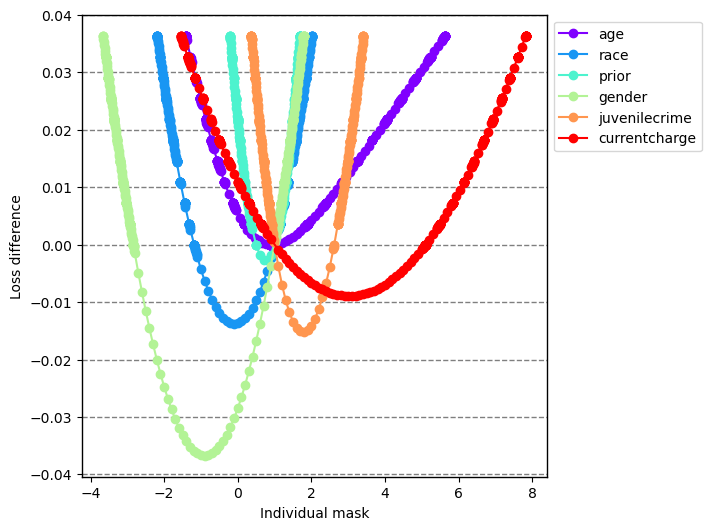

In [9]:
# Visualizing training process
m_training_process_vis(points_all_max_vic[1:], points_all_min_vic[1:], vlist, save=False, suffix='vic_raw')

In [17]:
m_all_sub_set = fis_reg_vic._get_all_m_with_t_in_range(points_all_max_vic, points_all_min_vic, fis_reg_vic.epsilon)

In [11]:
MR_all_ratio = np.ones((5, 11, 7, 2))
for idx, sub_boundary_rate in enumerate(np.arange(0.2, 1.2, 0.2)):
    for i in range(11):
        for j in range(7):
            for k in range(2):
                X0 = X_test.copy()
                X0[:, j] = X0[:, j] * m_all_sub_set[idx, i, j, k]
                MR_all_ratio[idx, i, j, k] = MR(j, X0, y_test, fis_reg_vic.model)

In [12]:
results_vic_comparison = np.zeros((7,4))
for i in range(7):
    results_vic_comparison[i, 0] = np.max(MR_all_ratio[:, :, i, :])
    results_vic_comparison[i, 1] = np.min(MR_all_ratio[:, :, i, :])
    results_vic_comparison[i, 2] = np.max(MR_all_ratio[:, :, i, :]) - np.min(MR_all_ratio[:, :, i, :])
    results_vic_comparison[i, 3] = np.mean(MR_all_ratio[:, :, i, :])
results_vic_comparison

array([[1.16909278, 1.        , 0.16909278, 1.14368728],
       [1.34131436, 1.2683287 , 0.07298566, 1.31958053],
       [1.05567532, 0.98779672, 0.06787859, 1.03760854],
       [1.0370578 , 0.98333221, 0.05372558, 1.02160008],
       [1.5107271 , 1.08177898, 0.42894813, 1.46473898],
       [1.28060154, 1.22051075, 0.06009078, 1.2608734 ],
       [1.03314641, 0.95638352, 0.07676289, 1.01431704]])

In [20]:
np.savetxt("../results/crime/crime_vic/result_vic_comparison.csv", results_vic_comparison, delimiter=",")

### Save and load outputs

## Optimal model explainer

In [6]:
fis_reg_optimal = fis_explainer(model_optimal, X_added_constant, y, epsilon_rate=0.1, loss_fn='classification', return_ref_main_effects=True,return_ref_pairwise_effects=True)
# m_all_optimal, points_all_max_optimal, points_all_min_optimal, fis_all_optimal = fis_reg_optimal._explore_m_in_R(fis_reg_optimal.epsilon, fis_reg_optimal.loss, fis_reg_optimal.v_list, fis_reg_optimal.model, fis_reg_optimal.input, fis_reg_optimal.output, delta=0.1, regression=False)

In [7]:
fis_reg_optimal.explain()

2023-06-12 14:15:53,565 INFO FIS_explainer _explore_m_in_R Searching started...
2023-06-12 14:15:53,580 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 0.0006162206720053964
2023-06-12 14:15:53,580 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 3.492492725132301e-05
2023-06-12 14:15:53,580 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 3.2256168975841604e-06
2023-06-12 14:15:53,580 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 3.198930490500018e-07
2023-06-12 14:15:53,628 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.1 * epsilon with m 1.1 achieves loss 0.0006162206720053964
2023-06-12 14:15:53,659 INFO feature_importance_helper greedy_search Feature 0 at boundary 0.1 * epsilon with m 1.2000000000000002 achieves loss 0.001825932524281093
2

(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)
(2, 8)
(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)
(2, 8)
(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)
(2, 8)
(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)
(2, 8)
(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)
(2, 8)
(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)
(2, 8)
(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)
(2, 8)
(5, 5)
(5, 5)
(3, 7)
(3, 7)
(4, 6)
(4, 6)
(6, 4)
(6, 4)
(7, 3)
(7, 3)
(8, 2)
(8, 2)
(9, 1)
(9, 1)
(1, 9)
(1, 9)
(2, 8)

2023-06-12 14:20:39,223 INFO FIS_explainer explain Calculation done
2023-06-12 14:20:39,223 INFO FIS_explainer explain Calculating FISC in the Rashomon set


(2, 8)
(2, 8)


2023-06-12 14:20:39,270 INFO FIS_explainer explain Calculation done
2023-06-12 14:20:39,285 INFO FIS_explainer explain Explanation is saved to C:\Users\chaoL\Documents\Project\FIS-in-Rashomon-set\experiments/../results/FIS-in-Rashomon-set-20230612-141541.json


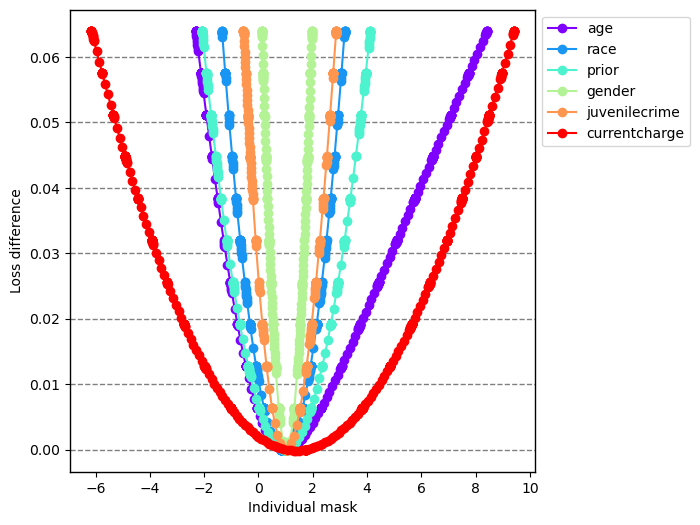

In [8]:
m_training_process_vis(fis_reg_optimal.FIS_main_effect_raw['points_all_max'][1:], fis_reg_optimal.FIS_main_effect_raw['points_all_min'][1:], vlist, save=False, suffix='optimal')

# Swarmplot
### Comparing with VIC, they only show pairwise information, missing higher order
### With prior, they compensate using others (information loss can be compensated by others) e.g. race is the minimum, but our plot shows that race and prior interaction is higher than others, as the interaction strength is strong, so the loss of information is not easy to compensate.

In [9]:
vlist_intercept = ["intercept", "age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]

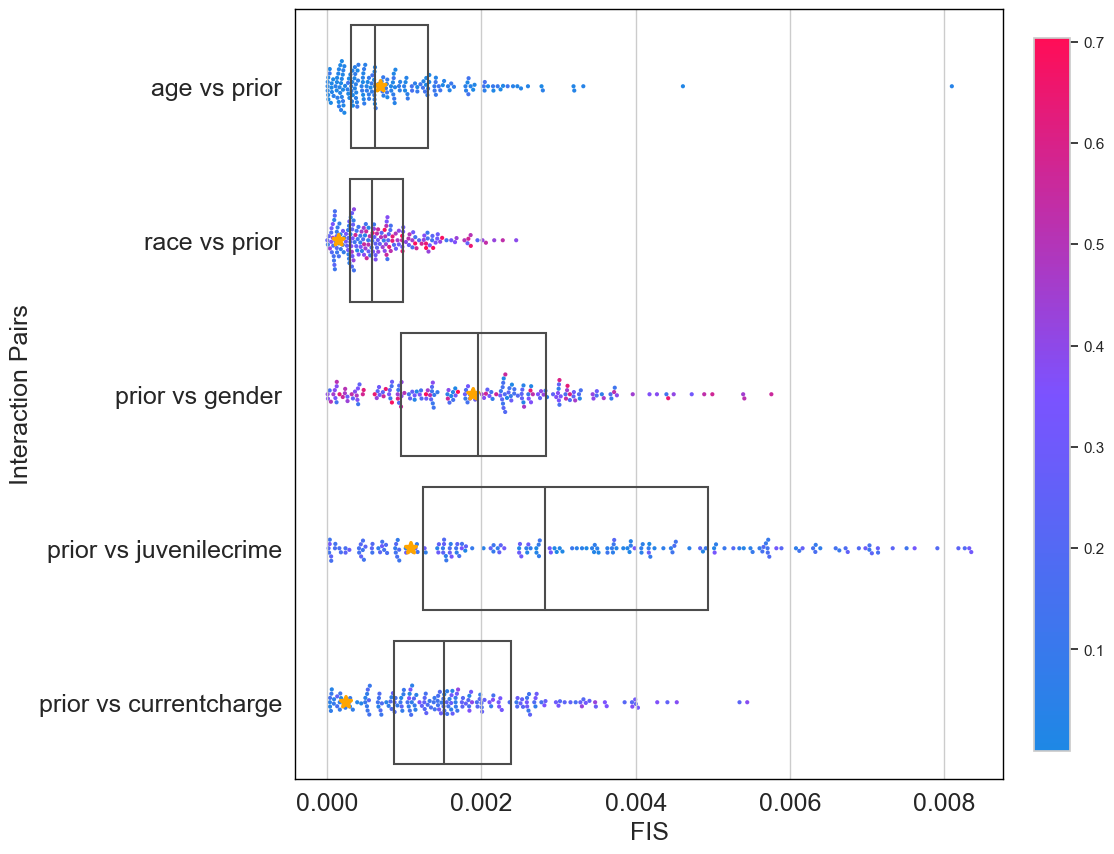

In [10]:
interest_pairs = [(1,3), (2,3) , (3,4), (3,5), (3,6)]
fis_reg_optimal.swarm_plot(interest_pairs, vname=vlist_intercept, plot_all=False, threshold=None, boxplot=True, save=False, suffix='prior')

## Halo plot

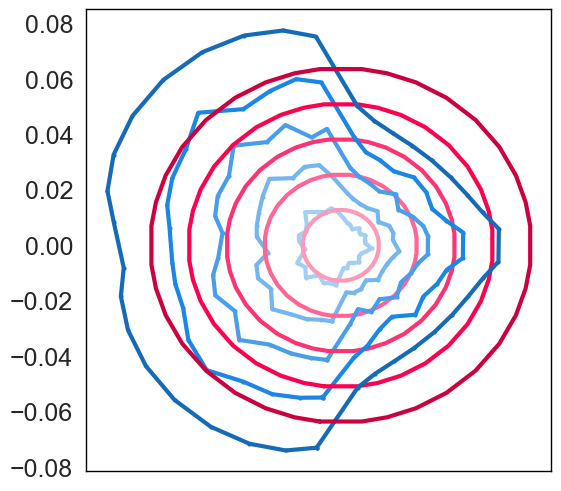

In [11]:
fis_reg_optimal.halo_plot(pair_idx=16, save=False)

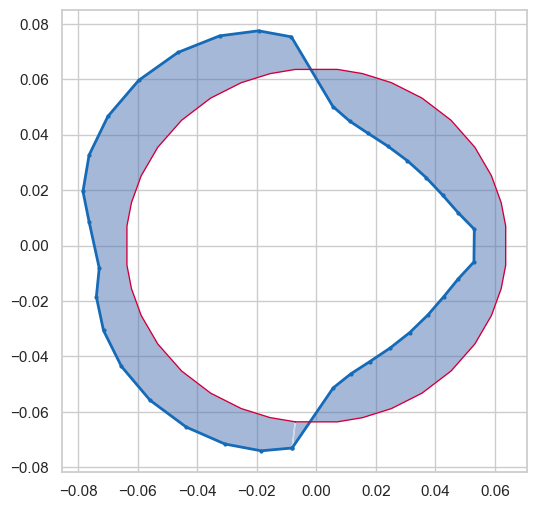

In [15]:
pairwise_vis_single(fis_reg_optimal.FIS_joint_effect_raw['loss_emp_all_pair_set'][-1], fis_reg_optimal.loss, fis_reg_optimal.epsilon, 16)

(3, 0, 7)
(3, 0, 7)
(3, 0, 7)
(1, 5, 4)
(1, 5, 4)
(1, 5, 4)
(1, 6, 3)
(1, 6, 3)
(1, 6, 3)
(8, 0, 2)
(8, 0, 2)
(8, 0, 2)
(2, 0, 8)
(2, 0, 8)
(2, 0, 8)
(4, 2, 4)
(4, 2, 4)
(4, 2, 4)
(3, 7, 0)
(3, 7, 0)
(3, 7, 0)
(7, 0, 3)
(7, 0, 3)
(7, 0, 3)
(0, 1, 9)
(0, 1, 9)
(0, 1, 9)
(2, 6, 2)
(2, 6, 2)
(2, 6, 2)
(5, 5, 0)
(5, 5, 0)
(5, 5, 0)
(2, 7, 1)
(2, 7, 1)
(2, 7, 1)
(0, 9, 1)
(0, 9, 1)
(0, 9, 1)
(1, 3, 6)
(1, 3, 6)
(1, 3, 6)
(1, 4, 5)
(1, 4, 5)
(1, 4, 5)
(0, 8, 2)
(0, 8, 2)
(0, 8, 2)
(3, 6, 1)
(3, 6, 1)
(3, 6, 1)
(4, 1, 5)
(4, 1, 5)
(4, 1, 5)
(6, 4, 0)
(6, 4, 0)
(6, 4, 0)
(9, 1, 0)
(9, 1, 0)
(9, 1, 0)
(5, 3, 2)
(5, 3, 2)
(5, 3, 2)
(5, 4, 1)
(5, 4, 1)
(5, 4, 1)
(0, 7, 3)
(0, 7, 3)
(0, 7, 3)
(0, 6, 4)
(0, 6, 4)
(0, 6, 4)
(3, 5, 2)
(3, 5, 2)
(3, 5, 2)
(4, 0, 6)
(4, 0, 6)
(4, 0, 6)
(6, 3, 1)
(6, 3, 1)
(6, 3, 1)
(2, 5, 3)
(2, 5, 3)
(2, 5, 3)
(9, 0, 1)
(9, 0, 1)
(9, 0, 1)
(4, 6, 0)
(4, 6, 0)
(4, 6, 0)
(5, 2, 3)
(5, 2, 3)
(5, 2, 3)
(1, 2, 7)
(1, 2, 7)
(1, 2, 7)
(3, 4, 3)
(3, 4, 3)
(3, 4, 3)
(3, 3, 4)


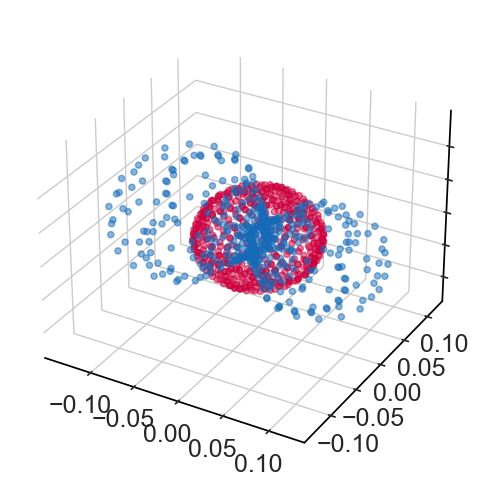

In [12]:
fis_reg_optimal.halo_plot_3D(pair_idx=(2,3,4), save=False)

In [31]:
find_all_n_way_feature_pairs(vlist, 3)

[('age', 'race', 'prior'),
 ('age', 'race', 'gender'),
 ('age', 'race', 'juvenilecrime'),
 ('age', 'race', 'currentcharge'),
 ('age', 'prior', 'gender'),
 ('age', 'prior', 'juvenilecrime'),
 ('age', 'prior', 'currentcharge'),
 ('age', 'gender', 'juvenilecrime'),
 ('age', 'gender', 'currentcharge'),
 ('age', 'juvenilecrime', 'currentcharge'),
 ('race', 'prior', 'gender'),
 ('race', 'prior', 'juvenilecrime'),
 ('race', 'prior', 'currentcharge'),
 ('race', 'gender', 'juvenilecrime'),
 ('race', 'gender', 'currentcharge'),
 ('race', 'juvenilecrime', 'currentcharge'),
 ('prior', 'gender', 'juvenilecrime'),
 ('prior', 'gender', 'currentcharge'),
 ('prior', 'juvenilecrime', 'currentcharge'),
 ('gender', 'juvenilecrime', 'currentcharge')]